## Step 0: Importing prerequisites

In [1]:
# Import necessary packages
import cv2
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from sklearn.metrics import average_precision_score
import time
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision.models as models
from transformers import ViTConfig, ViTModel
from ultralytics import YOLO

In [2]:
# Verify CPU availability
print(f"PyTorch version: {torch.__version__}")
print(f"CPU available: {torch.get_num_threads()} threads")

PyTorch version: 2.5.1
CPU available: 6 threads


## Step 1: Load dataset

In [6]:
# Define dataset directory
dataset_dir = r"D:\College\Semester 8\Skripsi\Program\Datasets\HybridViT_FER\test-4"

In [7]:
# Verify dataset directory structure
if not os.path.exists(os.path.join(dataset_dir, "train/images")) or \
   not os.path.exists(os.path.join(dataset_dir, "train/labels")) or \
   not os.path.exists(os.path.join(dataset_dir, "data.yaml")):
    raise FileNotFoundError(f"Dataset directory {dataset_dir} is missing required files (train/images, train/labels, data.yaml).")

In [8]:
# Create a custom dataset object to mimic Roboflow's dataset
class Dataset:
    def __init__(self, location):
        self.location = location

dataset = Dataset(dataset_dir)

## Step 2: Load models

In [9]:
# Define the HybridViT model (FER model)
class HybridViT(nn.Module):
    def __init__(self, num_classes=7, embed_dim=768):
        super(HybridViT, self).__init__()

        # ResNet-50 Backbone
        resnet = models.resnet50(pretrained=True)
        self.resnet_features = nn.Sequential(*list(resnet.children())[:-2])  # Remove FC and avgpool

        # Adjust channels and upsample to match ViT input size
        self.conv = nn.Conv2d(2048, 3, kernel_size=1)  # Match ViT's expected 3 channels
        self.upsample = nn.Upsample(size=(224, 224), mode='bilinear', align_corners=False)

        # ViT Configuration
        vit_config = ViTConfig(
            hidden_size=embed_dim,
            num_hidden_layers=12,
            num_attention_heads=12,
            intermediate_size=3072,
            image_size=224,
            patch_size=16,
            num_channels=3  # Standard RGB input
        )
        self.vit = ViTModel(vit_config)

        # Classifier
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        # Extract features with ResNet-50
        features = self.resnet_features(x)  # Shape: (batch, 2048, 7, 7)
        features = self.conv(features)  # Shape: (batch, 3, 7, 7)
        features = self.upsample(features)  # Shape: (batch, 3, 224, 224)

        # Pass through ViT
        outputs = self.vit(pixel_values=features)
        pooled_output = outputs.last_hidden_state[:, 0]  # Use [CLS] token

        # Classification
        logits = self.classifier(pooled_output)
        return logits

In [10]:
# Load YOLOv11s face detection model
yolo_model = YOLO(r"D:\College\Semester 8\Skripsi\Program\Models\YOLOv11s_Face_Detection.pt")

# Load HybridViT FER model
fer_model = HybridViT(num_classes=7)
fer_model.load_state_dict(torch.load(r"D:\College\Semester 8\Skripsi\Program\Models\HybridViT_ResNet-50_FER.pth", map_location=torch.device('cpu')))

c:\Users\ASUS\miniconda3\envs\vitfer_cpu\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ASUS\miniconda3\envs\vitfer_cpu\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_36176\2183769541.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/p

<All keys matched successfully>

In [11]:
# Define device
device = torch.device("cpu")
fer_model.to(device)

HybridViT(
  (resnet_features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): C

## Step 3: Define preprocessing for FER model

In [12]:
# Define preprocessing for FER model
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [13]:
# Class names (aligned with dataset)
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
dataset_to_fer_label_map = {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}

## Step 4: Create a dataset for evaluation

In [15]:
# Create a dataset for fine-tuning and evaluation
class ClassroomDataset(Dataset):
    def __init__(self, image_dir, label_dir, num_images=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
        if num_images:
            self.image_files = random.sample(self.image_files, min(num_images, len(self.image_files)))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_name = self.image_files[idx]
        image_path = os.path.join(self.image_dir, image_name)
        label_path = os.path.join(self.label_dir, image_name.replace('.jpg', '.txt'))

        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Could not load image: {image_path}")
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        true_labels = []
        bboxes = []
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) != 5:
                        print(f"Warning: Malformed label in {label_path}: {line.strip()}")
                        continue
                    label, x_center, y_center, width, height = map(float, parts)
                    label = int(label)
                    true_labels.append(dataset_to_fer_label_map[label])
                    h, w = image.shape[:2]
                    x_center, y_center, width, height = x_center * w, y_center * h, width * w, height * h
                    bboxes.append([x_center, y_center, width, height])

        return image_rgb, true_labels, bboxes, image_path

In [16]:
# Custom collate function
def custom_collate_fn(batch):
    images, true_labels, bboxes, paths = zip(*batch)
    return images, true_labels, bboxes, paths

## Step 5: Face detection and FER pipeline

In [17]:
# Face detection and FER pipeline (updated face cropping)
def detect_and_classify(image_rgb, yolo_model, fer_model, device, conf_threshold=0.25, yolo_input_size=1280):
    if isinstance(image_rgb, torch.Tensor):
        image_rgb = image_rgb.cpu().numpy()
        if image_rgb.shape[0] in [1, 3]:
            image_rgb = image_rgb.transpose(1, 2, 0)
        if image_rgb.dtype != np.uint8:
            image_rgb = (image_rgb * 255).astype(np.uint8)

    if not isinstance(image_rgb, np.ndarray):
        raise ValueError(f"image_rgb is not a NumPy array. Type: {type(image_rgb)}")
    if image_rgb.size == 0:
        raise ValueError("image_rgb is empty.")
    print(f"image_rgb shape: {image_rgb.shape}, dtype: {image_rgb.dtype}")

    h, w = image_rgb.shape[:2]
    scale = min(yolo_input_size / h, yolo_input_size / w)
    new_h, new_w = int(h * scale), int(w * scale)
    new_h = (new_h // 32) * 32
    new_w = (new_w // 32) * 32
    image_resized = cv2.resize(image_rgb, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

    results = yolo_model.predict(image_resized, conf=conf_threshold, verbose=False, imgsz=yolo_input_size)
    bboxes = []
    for result in results:
        boxes = result.boxes.xywh.cpu().numpy()
        scale_x, scale_y = w / new_w, h / new_h
        boxes[:, 0] *= scale_x
        boxes[:, 1] *= scale_y
        boxes[:, 2] *= scale_x
        boxes[:, 3] *= scale_y
        bboxes.extend(boxes)

    print(f"Detected {len(bboxes)} faces in image")

    predictions = []
    confidences = []
    faces_batch = []
    bbox_indices = []

    for idx, bbox in enumerate(bboxes):
        x_center, y_center, width, height = bbox
        # Add 20% padding to the bounding box
        padding = 0.2
        x1 = int(max(0, x_center - width / 2 * (1 + padding)))
        y1 = int(max(0, y_center - height / 2 * (1 + padding)))
        x2 = int(min(w, x_center + width / 2 * (1 + padding)))
        y2 = int(min(h, y_center + height / 2 * (1 + padding)))
        # Ensure minimum size of 64x64
        if x2 - x1 < 64:
            center_x = (x1 + x2) / 2
            x1 = int(max(0, center_x - 32))
            x2 = int(min(w, center_x + 32))
        if y2 - y1 < 64:
            center_y = (y1 + y2) / 2
            y1 = int(max(0, center_y - 32))
            y2 = int(min(h, center_y + 32))

        face = image_rgb[y1:y2, x1:x2]
        if face.size == 0:
            continue

        face_rgb = cv2.cvtColor(face, cv2.COLOR_RGB2BGR)
        face_tensor = preprocess(face_rgb)
        faces_batch.append(face_tensor)
        bbox_indices.append(idx)

    if faces_batch:
        faces_tensor = torch.stack(faces_batch).to(device)
        with torch.no_grad():
            logits = fer_model(faces_tensor)
            probs = torch.softmax(logits, dim=1)
            confidences_batch, predicted_batch = torch.max(probs, 1)
            for idx, pred, conf in zip(bbox_indices, predicted_batch, confidences_batch):
                predictions.append(pred.item())
                confidences.append(conf.item())

    return bboxes, predictions, confidences

## Step 6: Compute mAP and latency

In [18]:
# Compute mAP and latency (added debug output and all requested metrics)
def evaluate_pipeline(dataset, yolo_model, fer_model, device, batch_size=32, num_images=None):
    eval_dataset = ClassroomDataset(
        image_dir=os.path.join(dataset.location, "train/images"),
        label_dir=os.path.join(dataset.location, "train/labels"),
        num_images=num_images
    )
    dataloader = DataLoader(eval_dataset, batch_size=1, shuffle=False, num_workers=0, collate_fn=custom_collate_fn)

    all_true_labels = []
    all_pred_labels = []
    all_pred_probs = []
    total_latency = 0
    num_faces_processed = 0
    num_images_processed = 0  # Counter for images

    fer_model.eval()
    for batch_idx, (batch_images, batch_true_labels, batch_bboxes, batch_paths) in enumerate(dataloader):
        batch_images = batch_images[0]
        batch_true_labels = batch_true_labels[0]
        batch_bboxes = batch_bboxes[0]
        num_images_processed += 1  # Increment image counter

        print(f"Batch {batch_idx}: batch_bboxes type: {type(batch_bboxes)}, len: {len(batch_bboxes)}")
        if batch_bboxes:
            print(f"First bbox: {batch_bboxes[0]}")

        start_time = time.time()
        detected_bboxes, predictions, confidences = detect_and_classify(
            batch_images, yolo_model, fer_model, device, conf_threshold=0.25, yolo_input_size=1280
        )
        latency = time.time() - start_time
        total_latency += latency

        matched_predictions = []
        matched_true_labels = []
        for true_idx, (true_bbox, true_label) in enumerate(zip(batch_bboxes, batch_true_labels)):
            if len(true_bbox) != 4:
                print(f"Warning: Malformed bbox at index {true_idx}: {true_bbox}")
                continue
            if not detected_bboxes:
                continue
            true_center = np.array([true_bbox[0], true_bbox[1]])
            detected_centers = np.array([[bbox[0], bbox[1]] for bbox in detected_bboxes])
            distances = np.linalg.norm(detected_centers - true_center, axis=1)
            closest_idx = np.argmin(distances)
            distance = distances[closest_idx]

            if distance < 100:
                pred_label = predictions[closest_idx]
                matched_predictions.append(pred_label)
                matched_true_labels.append(true_label)
                # Debug: Log mismatched predictions
                if pred_label != true_label:
                    print(f"Mismatch in Batch {batch_idx}, Face {true_idx}: True={class_names[true_label]}, Predicted={class_names[pred_label]}")

                face = batch_images[int(max(0, true_bbox[1] - true_bbox[3]/2)):int(min(batch_images.shape[0], true_bbox[1] + true_bbox[3]/2)),
                                    int(max(0, true_bbox[0] - true_bbox[2]/2)):int(min(batch_images.shape[1], true_bbox[0] + true_bbox[2]/2))]
                if face.size == 0:
                    continue
                face_rgb = cv2.cvtColor(face, cv2.COLOR_RGB2BGR)
                face_tensor = preprocess(face_rgb).unsqueeze(0).to(device)
                with torch.no_grad():
                    logits = fer_model(face_tensor)
                    probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
                all_pred_probs.append(probs)
                num_faces_processed += 1

        all_true_labels.extend(matched_true_labels)
        all_pred_labels.extend(matched_predictions)

    all_true_labels = np.array(all_true_labels)
    all_pred_probs = np.array(all_pred_probs)
    ap_scores = []
    for class_idx in range(len(class_names)):
        true_binary = (all_true_labels == class_idx).astype(int)
        if len(true_binary) == 0 or np.sum(true_binary) == 0:
            continue
        class_probs = all_pred_probs[:, class_idx]
        ap = average_precision_score(true_binary, class_probs)
        ap_scores.append(ap)
    mAP = np.mean(ap_scores) if ap_scores else 0.0

    # Calculate metrics
    inference_time_per_face = (total_latency * 1000) / max(1, num_faces_processed)  # ms
    inference_time_per_image = (total_latency * 1000) / max(1, num_images_processed)  # ms
    fps_faces = num_faces_processed / total_latency if total_latency > 0 else 0  # FPS for faces
    fps_images = num_images_processed / total_latency if total_latency > 0 else 0  # FPS for images

    return mAP, ap_scores, inference_time_per_face, all_true_labels, all_pred_labels, inference_time_per_image, fps_faces, fps_images

## Step 7: Visualize results

In [19]:
# Visualize results
def visualize_results(dataset, yolo_model, fer_model, device, num_images=10):
    eval_dataset = ClassroomDataset(
        image_dir=os.path.join(dataset.location, "train/images"),
        label_dir=os.path.join(dataset.location, "train/labels"),
        num_images=num_images
    )

    fig, axes = plt.subplots(num_images, 1, figsize=(15, 5 * num_images))
    if num_images == 1:
        axes = [axes]

    for idx, (image_rgb, true_labels, true_bboxes, image_path) in enumerate(eval_dataset):
        if isinstance(image_rgb, torch.Tensor):
            image_rgb = image_rgb.cpu().numpy()
            if image_rgb.shape[0] in [1, 3]:
                image_rgb = image_rgb.transpose(1, 2, 0)
            if image_rgb.dtype != np.uint8:
                image_rgb = (image_rgb * 255).astype(np.uint8)

        detected_bboxes, predictions, confidences = detect_and_classify(
            image_rgb, yolo_model, fer_model, device, conf_threshold=0.25, yolo_input_size=1280  # Fixed: batch_images -> image_rgb
        )

        for bbox, pred, conf in zip(detected_bboxes, predictions, confidences):
            x_center, y_center, width, height = bbox
            x1 = int(x_center - width / 2)
            y1 = int(y_center - height / 2)
            x2 = int(x_center + width / 2)
            y2 = int(y_center + height / 2)
            cv2.rectangle(image_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)
            label = f"{class_names[pred]} ({conf:.2f})"
            cv2.putText(image_rgb, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        for bbox, true_label in zip(true_bboxes, true_labels):
            if len(bbox) != 4:
                print(f"Warning: Malformed bbox in visualization: {bbox}")
                continue
            x_center, y_center, width, height = bbox
            x1 = int(x_center - width / 2)
            y1 = int(y_center - height / 2)
            x2 = int(x_center + width / 2)
            y2 = int(y_center + height / 2)
            cv2.rectangle(image_rgb, (x1, y1), (x2, y2), (255, 0, 0), 1)
            label = f"True: {class_names[true_label]}"
            cv2.putText(image_rgb, label, (x1, y2 + 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

        axes[idx].imshow(image_rgb)
        axes[idx].set_title(f"Image {idx + 1}: {os.path.basename(image_path)}")
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

## Step 8: Run evaluation and save the results

In [21]:
# Run evaluation
print("\n=== Evaluation ===")
mAP, ap_scores, inference_time_per_face, true_labels, pred_labels, inference_time_per_image, fps_faces, fps_images = evaluate_pipeline(
    dataset, yolo_model, fer_model, device, num_images=None  # Match num_images to function
)

print(f"mAP: {mAP:.4f}")
for class_idx, ap in enumerate(ap_scores):
    print(f"AP for {class_names[class_idx]}: {ap:.4f}")
print(f"Inference Time per Face (Face Detection + FER): {inference_time_per_face:.2f} ms")
print(f"Inference Time per Image: {inference_time_per_image:.2f} ms")
print(f"FPS (Faces): {fps_faces:.2f}")
print(f"FPS (Images): {fps_images:.2f}")


=== Evaluation ===
Batch 0: batch_bboxes type: <class 'list'>, len: 38
First bbox: [467.5, 419.0, 33.0, 36.0]
image_rgb shape: (1080, 1920, 3), dtype: uint8
Detected 38 faces in image
Mismatch in Batch 0, Face 2: True=Neutral, Predicted=Angry
Mismatch in Batch 0, Face 3: True=Neutral, Predicted=Sad
Mismatch in Batch 0, Face 4: True=Neutral, Predicted=Sad
Mismatch in Batch 0, Face 6: True=Neutral, Predicted=Angry
Mismatch in Batch 0, Face 8: True=Neutral, Predicted=Happy
Mismatch in Batch 0, Face 11: True=Neutral, Predicted=Fear
Mismatch in Batch 0, Face 13: True=Neutral, Predicted=Sad
Mismatch in Batch 0, Face 14: True=Neutral, Predicted=Sad
Mismatch in Batch 0, Face 15: True=Sad, Predicted=Happy
Mismatch in Batch 0, Face 21: True=Happy, Predicted=Disgust
Mismatch in Batch 0, Face 22: True=Sad, Predicted=Neutral
Mismatch in Batch 0, Face 23: True=Neutral, Predicted=Angry
Mismatch in Batch 0, Face 28: True=Neutral, Predicted=Angry
Mismatch in Batch 0, Face 29: True=Angry, Predicted=Neu

In [22]:
metrics = {
    'mAP': float(mAP),
    'ap_scores': {class_names[i]: float(ap) for i, ap in enumerate(ap_scores)},
    'inference_time_per_face_ms': float(inference_time_per_face),
    'inference_time_per_image_ms': float(inference_time_per_image),
    'fps_faces': float(fps_faces),
    'fps_images': float(fps_images),
}

output_dir = r"D:\College\Semester 8\Skripsi\Program\Results\HybridViT_RT-FER_CPU"
os.makedirs(output_dir, exist_ok=True)
metrics_file = os.path.join(output_dir, 'evaluation_metrics.json')
with open(metrics_file, 'w') as f:
    json.dump(metrics, f, indent=4)
print(f"Evaluation metrics saved to {metrics_file}")

Evaluation metrics saved to D:\College\Semester 8\Skripsi\Program\Results\HybridViT_RT-FER_CPU\evaluation_metrics.json


## Step 9: Visualize results


=== Visualization ===
image_rgb shape: (1080, 1920, 3), dtype: uint8
Detected 37 faces in image
image_rgb shape: (1080, 1920, 3), dtype: uint8
Detected 26 faces in image
image_rgb shape: (1080, 1920, 3), dtype: uint8
Detected 29 faces in image
image_rgb shape: (1080, 1920, 3), dtype: uint8
Detected 36 faces in image
image_rgb shape: (1080, 1920, 3), dtype: uint8
Detected 39 faces in image
image_rgb shape: (1080, 1920, 3), dtype: uint8
Detected 36 faces in image
image_rgb shape: (1080, 1920, 3), dtype: uint8
Detected 39 faces in image
image_rgb shape: (1080, 1920, 3), dtype: uint8
Detected 38 faces in image
image_rgb shape: (1080, 1920, 3), dtype: uint8
Detected 38 faces in image
image_rgb shape: (1080, 1920, 3), dtype: uint8
Detected 29 faces in image


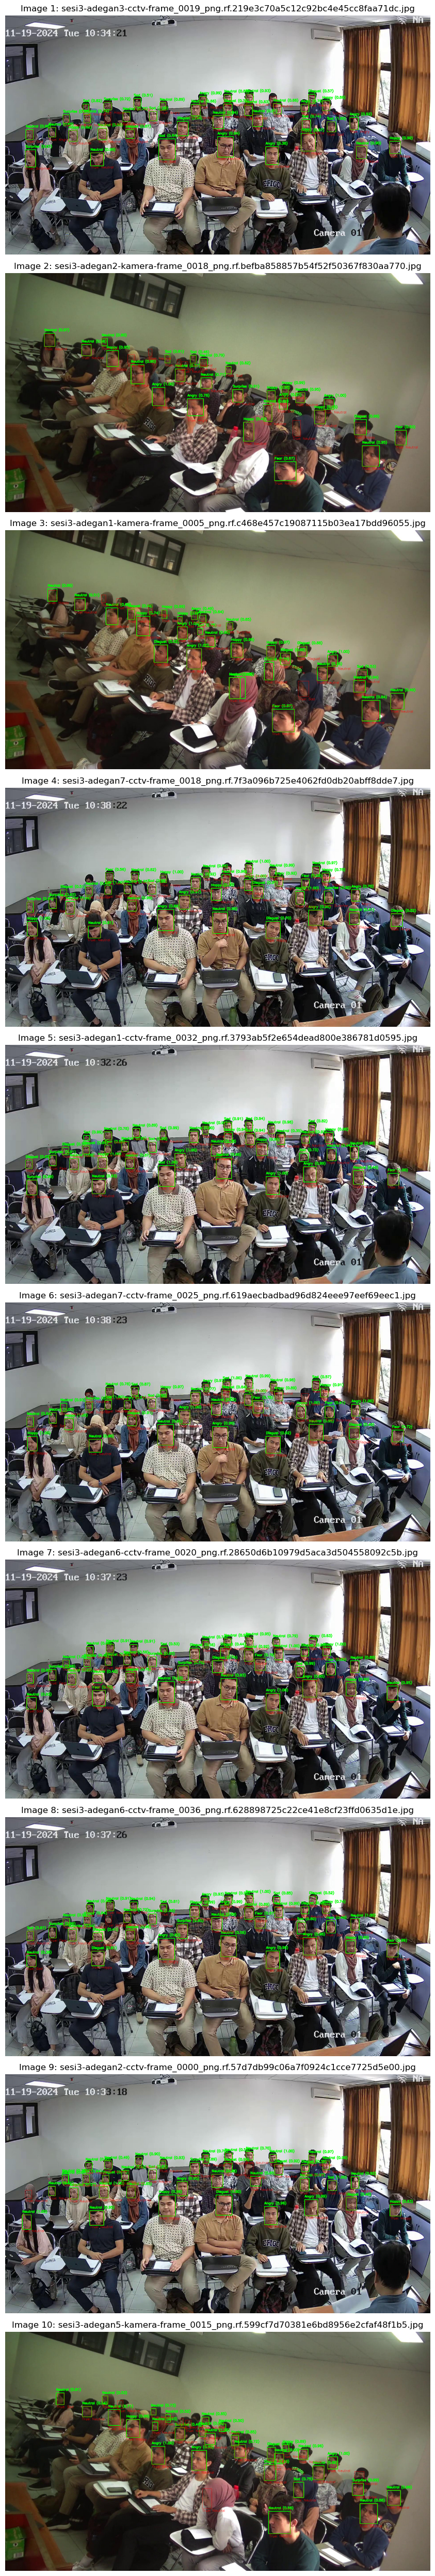

In [23]:
# Visualize results
print("\n=== Visualization ===")
visualize_results(dataset, yolo_model, fer_model, device, num_images=10)